In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ds_version = "V9"
root_data_path = os.path.join("..", "data", "training", ds_version)
data_path = os.path.join(root_data_path, "metadata")
only_validation = True

In [71]:
# without cropping
file_names = ["asphalt_prediction-V6_annotated_asphalt-20240214_151246.csv",
               "concrete_prediction-V6_annotated_concrete-20240214_151256.csv",
               "paving_stones_prediction-V6_annotated_paving_stones-20240214_151307.csv",
               "sett_prediction-V6_annotated_sett-20240214_151316.csv",
               "unpaved_prediction-V6_annotated_unpaved-20240214_151329.csv"]

In [66]:
# with cropping
file_names = ["asphalt_prediction-V6_annotated_asphalt-20240215_084707.csv",
            "concrete_prediction-V6_annotated_concrete-20240215_084716.csv",
            "paving_stones_prediction-V6_annotated_paving_stones-20240215_084725.csv",
            "sett_prediction-V6_annotated_sett-20240215_084733.csv",
            "unpaved_prediction-V6_annotated_unpaved-20240215_084745.csv"
            ]

In [3]:
# ds_version = "V7"
#file_names = ["asphalt_crop-half_seed1024_maxInf_prediction-V7_annotated_asphalt-20240222_083015.csv"]
#file_names = ["asphalt_crop-half_seed42_max100_prediction-V7_annotated_asphalt-20240222_082347.csv"]

# ds_version = "V9"
file_names = ["all_train_effnet_surface_quality_prediction-V9_annotated-20240318_130115.csv"]

In [4]:
pred = pd.DataFrame()
for file_name in file_names:
    surface = file_name.split("_")[0]
    print(f"reading {file_name}")
    df = pd.read_csv(os.path.join(data_path, "model_predictions", file_name))
    df["surface_pred"] = surface
    pred = pd.concat([pred, df])

pred.rename(columns={"Image": "image_id", "Prediction": "quality_float_pred", "Level_0": "quality_label_pred"}, inplace=True)

reading all_train_effnet_surface_quality_prediction-V9_annotated-20240318_130115.csv


In [16]:
annot = pd.read_csv(os.path.join(data_path, "annotations_combined.csv"))
annot.rename(columns={"surface": "surface_true", "smoothness": "quality_label_true"}, inplace=True)
annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [17]:
annot.groupby(["surface_true", "quality_label_true"]).size()

surface_true   quality_label_true
asphalt        bad                    113
               excellent              716
               good                  1251
               intermediate           598
concrete       bad                     53
               excellent              189
               good                   330
               intermediate           242
paving_stones  bad                     23
               excellent              326
               good                   668
               intermediate           191
sett           bad                    508
               good                    91
               intermediate           650
unpaved        bad                    332
               intermediate           293
               very_bad               155
dtype: int64

In [18]:
df = pred.set_index("image_id").join(annot[["image_id", "surface_true", "quality_label_true", "quality_float_true"]].set_index("image_id"), how="left")

In [19]:
df.groupby(["surface_true", "quality_label_true"]).size()

surface_true   quality_label_true
asphalt        bad                    565
               excellent             3580
               good                  6265
               intermediate          3000
concrete       bad                    265
               excellent              945
               good                  1650
               intermediate          1215
paving_stones  bad                    115
               excellent             1630
               good                  3345
               intermediate           960
sett           bad                   2540
               good                   455
               intermediate          3250
unpaved        bad                   1660
               intermediate          1465
               very_bad               775
dtype: int64

In [9]:
df_valid = df[df.is_in_validation == 1]
df_train = df[df.is_in_validation == 0]

In [10]:
df.groupby(["is_in_validation", "surface_true", "quality_label_true"]).size().to_csv("test.csv")

## Global measures

In [14]:
def compute_measures(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    # "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    # "r_square": r2_score(true_float, pred_float),
    # "mse": mean_squared_error(true_float, pred_float)
    }
    # m["rmse"] = np.sqrt(m["mse"])
    return m

In [15]:
# all
gm = compute_measures(df.quality_float_true, df.quality_float_pred)
gm_valid = compute_measures(df_valid.quality_float_true, df_valid.quality_float_pred)
gm_train = compute_measures(df_train.quality_float_true, df_train.quality_float_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(2)

,all,validation,train
accuracy,0.03,0.04,0.0


In [76]:
if only_validation:
    df = df_valid

## Measures by surface class

In [77]:
gm_surface = pd.DataFrame()
for surface in df.surface_true.unique():
    df_ = df[df.surface_true == surface]
    gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,paving_stones,sett,unpaved
accuracy,0.52,0.56,0.50,0.63,0.54
correlation,0.51,0.57,0.27,0.43,0.64
r_square,0.18,0.20,-0.38,0.02,0.12
mse,0.45,0.52,0.57,0.35,0.46
rmse,0.67,0.72,0.76,0.59,0.68


## compare float values

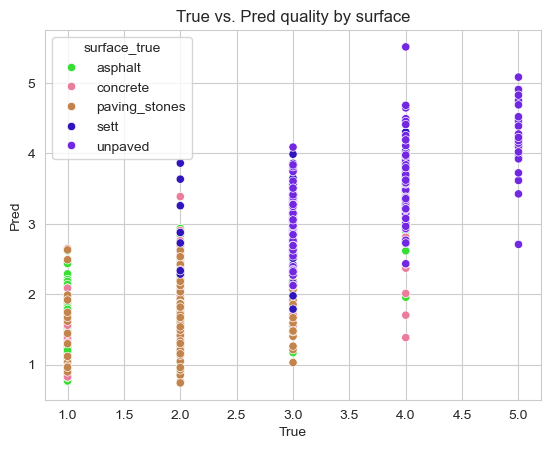

In [78]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df.surface_true.unique()}

sns.scatterplot(data=df, x="quality_float_true", y="quality_float_pred", hue="surface_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


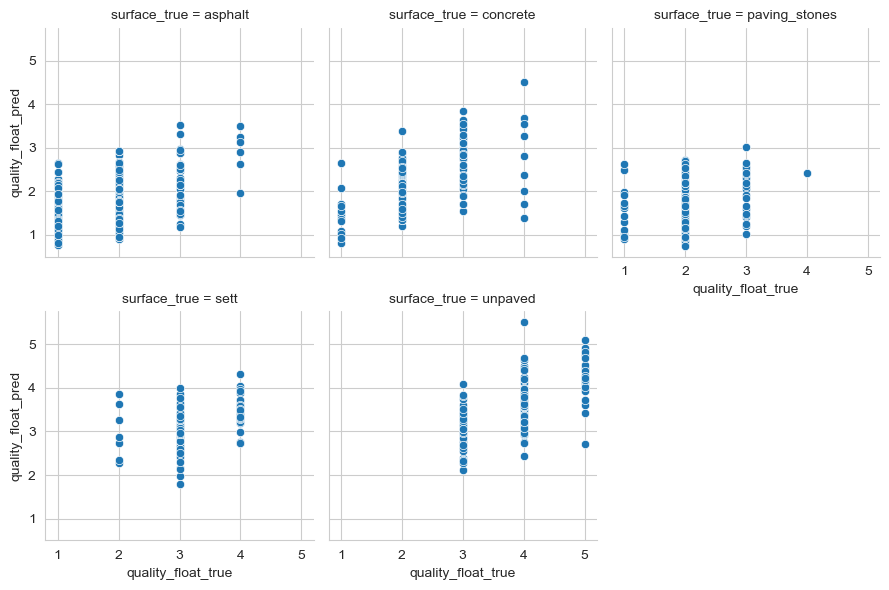

In [79]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df, col="surface_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [11]:
df["deviation"] = df.quality_float_true - df.quality_float_pred

**Overall**

<Axes: >

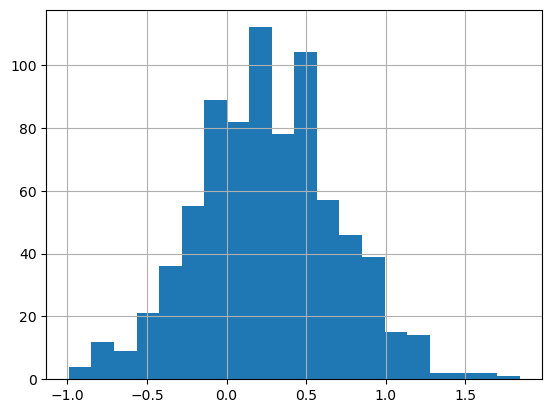

In [12]:
df.deviation.hist(bins=20)

**by surface**

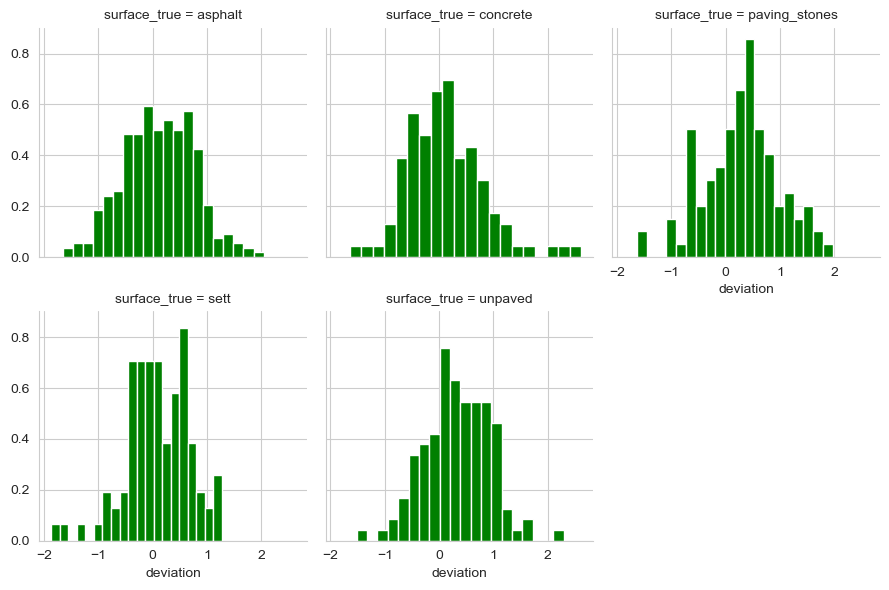

In [82]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df, col="surface_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

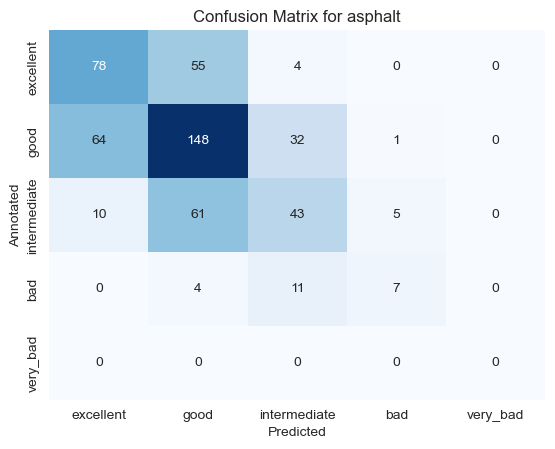

In [46]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df.surface_true.unique():
    _df = df[(df.surface_true == surface)]
    cm = confusion_matrix(_df.quality_label_true, _df.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()

In [106]:
# Extract predicted and ground truth values
for class_name in df['surface_clean'].unique():
    _df1 = df[df['surface_pred'] == class_name]
    _df2 = df[df['surface_clean'] == class_name]
    class_precision = sum(_df1.surface_clean == class_name) / len(_df1)
    class_recall = sum(_df2.surface_pred == class_name) / len(_df2)

    print(f"Class: {class_name}")
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")


Class: asphalt
Count: 292
Precision: 0.52
Recall: 0.52
------------------------
Class: concrete
Count: 108
Precision: 0.56
Recall: 0.56
------------------------
Class: paving_stones
Count: 110
Precision: 0.52
Recall: 0.5
------------------------
Class: sett
Count: 99
Precision: 0.63
Recall: 0.63
------------------------
Class: unpaved
Count: 125
Precision: 0.6
Recall: 0.54
------------------------


/Users/alexandra/opt/anaconda3/envs/sai_dc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexandra/opt/anaconda3/envs/sai_dc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# all images that were incorrectly classified
df["deviation_abs"] = abs(df.deviation)    
misclassification = df[(df.deviation_abs > 1) & (df.is_in_validation == 1)]

In [16]:
misclassification = misclassification.sort_values("image_id")
misclassification.reset_index( inplace=True)
misclassification[["image_id", "is_in_validation", 
                   "surface_true", "surface_pred", "quality_float_pred", "quality_float_true", 
                   "quality_label_pred", "quality_label_true", "deviation"]
                   ].to_csv(os.path.join(data_path, "model_predictions", "misclassification.csv"), index=False)

In [19]:
# store missclassified images in folder
import shutil

path = os.path.join(data_path, "model_predictions", "misclassified_images")
os.makedirs(path, exist_ok=True)
for i in range(len(misclassification)):  # len(misclassification)
    img = misclassification.loc[i]
    img_path = os.path.join(root_data_path, "annotated")
    destination_folder_path = os.path.join(path, img.surface_pred, img.quality_label_pred)
    os.makedirs(destination_folder_path, exist_ok=True)
    destination_path = os.path.join(destination_folder_path, f"{img.image_id}.jpg")
    image_filename = os.path.join(img_path, img.surface_true, img.quality_label_true, f"{img.image_id}.jpg")
    shutil.copy(image_filename, destination_path)

In [141]:
# store missclassified images in folder
# path = "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/metadata/model_predictions/VGG16_V4_not_annotated/missclassified_wo_nostreet"
# os.makedirs(path, exist_ok=True)
# for image_id in misclassification_wo_nostreet.index:
#     destination_path = os.path.join(path, f"{image_id}.jpg")
#     image_filename = os.path.join("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/unsorted_images", f"{image_id}.jpg")
#     shutil.copy(image_filename, destination_path)